In [2]:
from os import listdir
from os.path import splitext
from pathlib import Path
import os
import numpy as np
import torch
from PIL import Image,ImageChops
from torch.utils.data import Dataset
import random
import torchvision.transforms as T

In [18]:
class SatelliteDataset(Dataset):
    def __init__(self,
                 preimages_dir,
                 premasks_dir,
                 postimages_dir,
                 postmasks_dir,
                 increase=0,
                 values=[[1, 1], False, False, False],
                 probabilities=[0, 0, 0, 0],
                 seed=42):
        """
        Parameters
        ----------
        increase : int, optional
            amount of additional images randomly copied from directiory
        values: array
            array of augmentation values [scale bounds([int,int]), flip(bool), rotate(bool), roll(bool)]
        probabilities : array
            probabilies of augmentation values being applied to an image
        seed : int
            random seed
        """
        random.seed(seed)
        self.postimages_dir = postimages_dir
        self.postmasks_dir = postmasks_dir
        self.preimages_dir = preimages_dir
        self.premasks_dir = premasks_dir
        self.values = values
        self.probabilities = probabilities
        self.ids = [file.split('_')[0:2] for file in listdir(postimages_dir) if not file.startswith('.')]
        assert values[0][1] - values[0][0] >= 0, '2nd scale value must be equal or greater than the 1st'
        assert values[0][1] > 0 and values[0][0] > 0, 'scale values must be greater than 0'
        assert isinstance(increase, int), 'increase must be integer'
        assert isinstance(seed, int), 'seed must be integer'

        if (increase > 0):
            copyid = self.ids
            newid = []
            for i in range(increase + len(self.ids)):
                ranint = random.randint(0, len(self.ids) - 1)
                newid.append(copyid[ranint])
            self.ids = newid
        if not self.ids:
            raise RuntimeError(f'No input file found in {postimages_dir}, make sure you put your images there')

    def __len__(self):
        return len(self.ids)

    def preprocess(self,
                   pil_img=None,
                   scale=[1, 1],
                   flip=False,
                   rotate=False,
                   roll=False,
                   is_mask=False,
                   randlist=[0, 0, 0, 0, 0, 0]
                   ):
        """
        Parameters
        ----------
        pil_img : PILLOW Image
            Image input
        scale : array
            Scale bounds of image
        flip : bool
            Flip preprocessing
        rotate : bool
            Rotate preprocessing
        roll : bool
            Roll preprocessing
        is_mask: bool
            Determines whether image is treated as a mask
        randlist : array
            Random values for preprocessing
        """
        w, h = pil_img.size
        if (scale != [1, 1]):
            scalediff = randlist[0] * (self.values[0][1] - self.values[0][0])
            newscale = self.values[0][0] + scalediff
            newW, newH = int(newscale * w), int(newscale * h)
            left = int((newW - w) / 2)
            top = int((newH - h) / 2)
            right = int((w + newW) / 2)
            bottom = int((h + newH) / 2)
            if (newW > w):
                pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
                pil_img = pil_img.crop((left, top, right, bottom))
                pil_img = pil_img.resize((w, h), resample=Image.NEAREST if is_mask else Image.BICUBIC)
            if (newW < w):
                pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
                if (is_mask):
                    img_new = Image.new('L', (w, h), (0))
                    img_new.paste(pil_img, (int(-1 * left), int(-1 * top)))
                    pil_img = img_new
                else:
                    img_new = Image.new('RGB', (w, h), (0, 0, 0))
                    img_new.paste(pil_img, (int(-1 * left), int(-1 * top)))
                    pil_img = img_new
        if (self.values[1] == True):
            if (randlist[1] > 0.5):
                pil_img = pil_img.transpose(Image.FLIP_LEFT_RIGHT)
            if (randlist[2] > 0.5):
                pil_img = pil_img.transpose(Image.FLIP_TOP_BOTTOM)
        if (self.values[2] == True):
            pil_img = pil_img.rotate(randlist[3] * 90, resample=Image.NEAREST if is_mask else Image.BICUBIC)
        if (self.values[3] == True):
            pil_img = ImageChops.offset(pil_img, int(randlist[4] * 512), int(randlist[5] * 512))
        img_ndarray = np.asarray(pil_img)
        #
        print(randlist)
        if not is_mask:
            if img_ndarray.ndim == 2:
                img_ndarray = img_ndarray[np.newaxis, ...]
            else:
                img_ndarray = img_ndarray.transpose((2, 0, 1))

            img_ndarray = img_ndarray / 255

        return img_ndarray

    @staticmethod
    def load(filename):
        return Image.open(filename)

    def __getitem__(self, idx):
        name = self.ids[idx]
        postmask_file = str(self.postmasks_dir) + '\\' + name[0] + '_' + name[1] + '_post_disaster.png'
        premask_file = str(self.premasks_dir) + '\\' + name[0] + '_' + name[1] + '_pre_disaster.png'
        postimg_file = str(self.postimages_dir) + '\\' + name[0] + '_' + name[1] + '_post_disaster.png'
        preimg_file = str(self.preimages_dir) + '\\' + name[0] + '_' + name[1] + '_pre_disaster.png'
        postmask = self.load(postmask_file)
        postimg = self.load(postimg_file)
        premask = self.load(premask_file)
        preimg = self.load(preimg_file)
        assert postimg.size == postmask.size, \
            f'Image and mask {name} should be the same size, but are {postimg.size} and {posmask.size}'
        assert preimg.size == premask.size, \
            f'Image and mask {name} should be the same size, but are {preimg.size} and {premask.size}'
        prearray = [[1, 1], False, False, False]
        if (random.random() < self.probabilities[0]):
            prearray[0] = self.values[0]
        if (random.random() < self.probabilities[1]):
            prearray[1] = self.values[1]
        if (random.random() < self.probabilities[2]):
            prearray[2] = self.values[2]
        if (random.random() < self.probabilities[3]):
            prearray[3] = self.values[3]
        randlist = [random.random(), random.random(), random.random(), random.randrange(4), random.random(),
                    random.random()]
        postimg = self.preprocess(pil_img=postimg,
                                  randlist=randlist,
                                  scale=prearray[0],
                                  flip=prearray[1],
                                  rotate=prearray[2],
                                  roll=prearray[3],
                                  is_mask=False
                                  )
        postmask = self.preprocess(postmask,
                                   randlist=randlist,
                                   scale=prearray[0],
                                   flip=prearray[1],
                                   rotate=prearray[2],
                                   roll=prearray[3],
                                   is_mask=True)
        preimg = self.preprocess(preimg,
                                 randlist=randlist,
                                 scale=prearray[0],
                                 flip=prearray[1],
                                 rotate=prearray[2],
                                 roll=prearray[3],
                                 is_mask=False)
        premask = self.preprocess(premask,
                                  randlist=randlist,
                                  scale=prearray[0],
                                  flip=prearray[1],
                                  rotate=prearray[2],
                                  roll=prearray[3],
                                  is_mask=True)

        return {
            'postimage': torch.as_tensor(postimg.copy()).float().contiguous(),
            'postmask': torch.as_tensor(postmask.copy()).long().contiguous(),
            'preimage': torch.as_tensor(preimg.copy()).float().contiguous(),
            'premask': torch.as_tensor(premask.copy()).long().contiguous()
        }

In [19]:
# dataset param
img_home_path = "C:/Users/liuyi/segment/ubdd/xbd"
pre_dir_img = img_home_path + '/test/images'
post_dir_img = img_home_path + '/test/images'
pre_dir_mask = img_home_path + '/test/masks'
post_dir_mask = img_home_path + '/test/masks'

In [20]:
train = SatelliteDataset(pre_dir_img, pre_dir_mask,post_dir_img, post_dir_mask, values =  [[.8,2], True, False, False], probabilities = [0,1,0,0],increase = 0)


In [21]:
import matplotlib.pyplot as plt

[0.15547949981178155, 0.9572130722067812, 0.33659454511262676, 0, 0.3799273006373374, 0.3589793804846284]
[0.15547949981178155, 0.9572130722067812, 0.33659454511262676, 0, 0.3799273006373374, 0.3589793804846284]
[0.15547949981178155, 0.9572130722067812, 0.33659454511262676, 0, 0.3799273006373374, 0.3589793804846284]
[0.15547949981178155, 0.9572130722067812, 0.33659454511262676, 0, 0.3799273006373374, 0.3589793804846284]


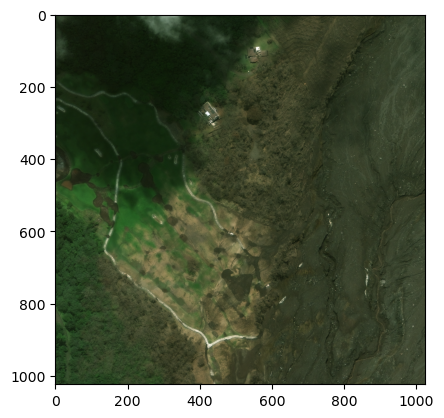

In [27]:
plt.imshow(train[0]['postimage'].permute(1,2,0),vmin=0,vmax=255) #permute(1, 2, 0)将维度从 重新排序(C, H, W)为(H, W, C)。

[0.12482616285320935, 0.9222953720281599, 0.07880019807845817, 2, 0.8294046642529949, 0.6185197523642461]
[0.12482616285320935, 0.9222953720281599, 0.07880019807845817, 2, 0.8294046642529949, 0.6185197523642461]
[0.12482616285320935, 0.9222953720281599, 0.07880019807845817, 2, 0.8294046642529949, 0.6185197523642461]
[0.12482616285320935, 0.9222953720281599, 0.07880019807845817, 2, 0.8294046642529949, 0.6185197523642461]


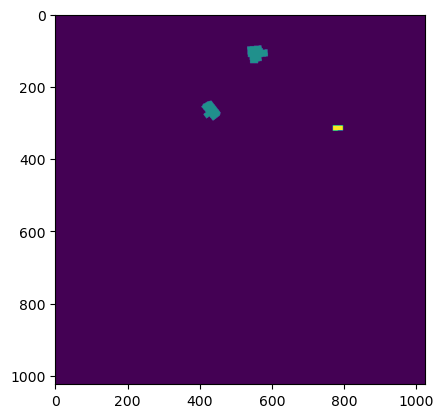

In [28]:
plt.imshow(train[0]['postmask'])

In [23]:
for batch in [train[0]]:
    preimage, postimage, post_masks, pre_masks = batch['preimage'], batch['postimage'], batch['postmask'], batch['premask']

[0.7160196129224035, 0.7013249735902359, 0.41951982096165874, 3, 0.5892656838759087, 0.8094304566778266]
[0.7160196129224035, 0.7013249735902359, 0.41951982096165874, 3, 0.5892656838759087, 0.8094304566778266]
[0.7160196129224035, 0.7013249735902359, 0.41951982096165874, 3, 0.5892656838759087, 0.8094304566778266]
[0.7160196129224035, 0.7013249735902359, 0.41951982096165874, 3, 0.5892656838759087, 0.8094304566778266]


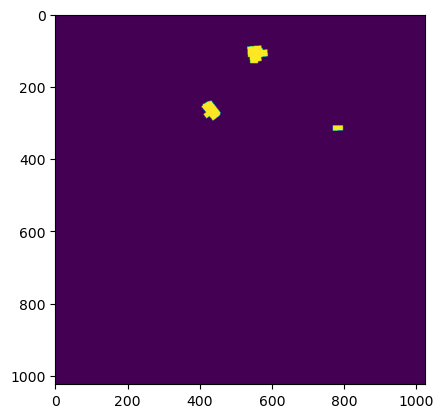

In [25]:
plt.imshow(pre_masks)

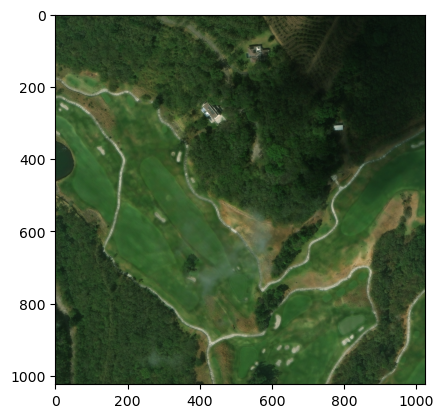

In [26]:
plt.imshow(preimage.permute(1,2,0),vmin=0,vmax=255)